# Klasteriranje talijanskih vina (Wine dataset)

**Emil Baltić Hrsan**

Cilj prvog dijela ove zadaće je pokušati predvidjeti dnevnu 'Close' cijenu dionica Apple-a na temelju podataka o kretanju te dionice prijašnjih 10 dana.

Prvo uvozimo neke osnovne biblioteke koje će nam trebati u radu.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import yfinance as yf

Zatim pomoću biblioteke `yfinance` preuzimamo podatke o dnevnoj cijeni dionica Apple-a u posljednjih 10 godina.

In [2]:
aapl = yf.download("AAPL",start="2015-08-01", end="2025-08-01")
aapl

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-08-03,26.496565,27.420499,26.290748,27.181126,279904000
2015-08-04,25.646454,26.331015,25.335493,26.268376,496554400
2015-08-05,25.816469,26.272844,25.078216,25.268372,397250400
2015-08-06,25.872656,26.180531,25.645684,26.061426,211612000
2015-08-07,25.960297,26.124347,25.731077,25.749056,154681600
...,...,...,...,...,...
2025-07-25,213.637543,214.996002,213.158076,214.456605,40268800
2025-07-28,213.807358,214.606454,212.818475,213.787376,37858000


Provjeravamo ponavljaju li se datumi.

In [3]:
aapl.index.duplicated().any()

np.False_

Zatim provjeravamo ima li nedostajućih podataka.

In [4]:
aapl.isnull().sum()

Price   Ticker
Close   AAPL      0
High    AAPL      0
Low     AAPL      0
Open    AAPL      0
Volume  AAPL      0
dtype: int64

Nakon toga u `array` intervali pohranjujemo sve podatke o dionici u uzastopnih 10 dana i na posljednjem mjestu stavljamo 'Close' cijenu 11. dana.

In [5]:
intervali = []

for i in range(10, len(aapl)):
    interval = aapl.iloc[i-10:i][['Close', 'High', 'Low', 'Open', 'Volume']].values.flatten()
    interval = np.append(interval, aapl.iloc[i]['Close'])
    intervali.append(interval)

intervali = np.array(intervali)
print(intervali)
print(intervali.shape)

[[2.64965649e+01 2.74204988e+01 2.62907476e+01 ... 2.56906276e+01
  1.71718000e+08 2.63288403e+01]
 [2.56464539e+01 2.63310150e+01 2.53354930e+01 ... 2.60771471e+01
  1.63538800e+08 2.61805305e+01]
 [2.58164692e+01 2.62728437e+01 2.50782159e+01 ... 2.61647998e+01
  1.38242800e+08 2.58456898e+01]
 ...
 [2.08872955e+02 2.11649803e+02 2.08683168e+02 ... 2.13787376e+02
  3.78580000e+07 2.11030502e+02]
 [2.09921768e+02 2.12159219e+02 2.08403487e+02 ... 2.13937192e+02
  5.14117000e+07 2.08813019e+02]
 [2.09781921e+02 2.11559902e+02 2.09352401e+02 ... 2.11659779e+02
  4.55125000e+07 2.07334702e+02]]
(2504, 51)


Sada definiramo X i y varijable te dijelimo podatke na train i test podskupove. Ne koristimo funkciju  `train_test_split` nego ih dijelimo ručno bez mijenjanja redoslijeda te ostavljamo razmak od 9 dana između train i test skupa kako bi izbjegli 'data leakage' pri treniranju i testiranju modela.

In [6]:
X = intervali[:, :-1]
y = intervali[:, -1]

train_end = int(0.8 * len(X)) - 9

X_train = X[:train_end]
y_train = y[:train_end]

X_test = X[train_end + 9:]
y_test = y[train_end + 9:]

Definiramo `Pipeline` kojim normaliziramo podatke i provodimo linearnu regresiju.

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

pipeline = Pipeline([('scaler', StandardScaler()),('model', LinearRegression())])

Zatim provodimo unakrsnu validaciju modela koristeći funkciju `TimeSeriesSplit` s parametrom gap = 9 za pravilno razdvajanje preklapajućih vremenskih intervala te onda primjenjujemo funkciju `cross_val_score`.

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, gap=9)

scores = cross_val_score(pipeline, X_train, y_train, cv=tss, scoring="neg_root_mean_squared_error")
neg_rmse_cv = scores.mean()
print(-neg_rmse_cv)

scores = cross_val_score(pipeline, X_train, y_train, cv=tss, scoring="r2")
r2_cv = scores.mean()
print(r2_cv)

1.8514714762969693
0.9759392967282251


Na kraju primjenjujemo pipeline na cijeli train set i evaluiramo model na test skupu.

In [9]:
from sklearn.metrics import r2_score, root_mean_squared_error

pipeline.fit(X_train, y_train)
y_test_pred = pipeline.predict(X_test)
rmse = root_mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
print(rmse)
print(r2)

3.6228672014724985
0.977007993004729


Zaključujemo da model vrlo dobro objašnjava varijancu varijable koju smo pokušali predvidjeti odnosno 'Close' cijenu dionica Apple na kraju 11. dana jer $R^2$-vrijednost na train i test setu iznosi gotovo 0.98. 
Međutim, `RMSE` vrijednost test skupa je gotovo dvostruko veća od vrijednosti train skupa što znači da model lošije predviđa podatke izvan train skupa.

Sada ćemo na istom skupu podataka provesti klasifikaciju modelom logističke regresije. y varijablu ćemo funkcijom `np.diff` pretvoriti u kategorijalnu tako što ćemo s 1 označiti ako je cijena rasla u odnosu na dan prije, a s 0 suprotno. Podjelu na test i train skup zadržavamo iz gornjeg dijela sa prilagodbama zbog izbacivanja prvog podatka pri računanju postotne razlike.

In [10]:
y_logreg = (np.diff(intervali[:, -1]) > 0).astype(int)
X_logreg = X[1:]

X_train_logreg = X_logreg[:train_end]
y_train_logreg = y_logreg[:train_end]

X_test_logreg = X_logreg[train_end + 9:]
y_test_logreg = y_logreg[train_end + 9:]

Definiramo `Pipeline`.

In [11]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(multi_class='multinomial',random_state=16))])

Zatim provodimo unakrsnu validaciju na isti način kao i prije.

In [12]:
scores = cross_val_score(logreg, X_train_logreg, y_train_logreg, cv=tss)

print(scores.mean())

0.5132530120481927


Dobivena vrijednost je malo veća od 0.5 što nam govori da model vjerojatno neće biti koristan.

Provodimo logističku regresiju na train skupu.

In [13]:
logreg.fit(X_train_logreg, y_train_logreg)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(multi_class='multinomial',
                                    random_state=16))])

In [14]:
print(logreg.named_steps['model'].intercept_)
print(logreg.named_steps['model'].coef_)

[0.05869356]
[[-0.49704043  0.18192186 -0.3546739   0.08281117 -0.00204631  0.10381055
  -0.22266153  0.3656986   0.14286238 -0.04734231 -0.32894733 -0.00825686
   0.1375379   0.20412284  0.07850654 -0.09855669  0.10181089 -0.00772061
   0.09139561 -0.09203806 -0.1285526  -0.07929089 -0.11782465 -0.07876031
   0.01874682  0.18332921  0.26378518  0.11653378  0.19684318 -0.02601483
   0.02604402 -0.00370952 -0.10392182  0.00548036  0.00912666  0.10557003
  -0.01179492 -0.00864946 -0.09224659 -0.01381751  0.03616487  0.37620088
   0.33516289  0.29149539  0.04655638 -0.46371664 -0.22372083 -0.17733018
  -0.38743855 -0.03071395]]


Evaluirajmo sada model koristeći neke standardne metode.

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

y_pred = logreg.predict(X_test_logreg)
print("Accuracy:", accuracy_score(y_test_logreg, y_pred))
print("Precision:", precision_score(y_test_logreg, y_pred))
print("Recall:", recall_score(y_test_logreg, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test_logreg, y_pred))

Accuracy: 0.49
Precision: 0.5340501792114696
Recall: 0.5437956204379562
Confusion matrix:
 [[ 96 130]
 [125 149]]


Model logističke regresije postiže točnost od 49%, što je gotovo jednako slučajnom pogađanju. Ovo je u skladu s hipotezom efikasnog tržišta, prema kojoj je cijena dionica približno slučajna šetnja i kratkoročno ju je nemoguće predvidjeti.
Kada model predvidi da cijena raste, točan je gotovo 54%, a kada cijena stvarno raste, točno predviđanje napravi također u 54% slučajeva.

Iako su precision i recall nešto veći od 0.5, usporedimo model sa modelom koji uvijek predviđa da će cijena rasti. Za to ćemo upotrijebiti `DummyClassifier` koji se također nalazi u biblioteci `sklearn`. 

In [16]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(constant = 1)
dummy.fit(X_train_logreg, y_train_logreg)
y_pred_dummy = dummy.predict(X_test_logreg)

print("Accuracy:", accuracy_score(y_test_logreg, y_pred_dummy))
print("Precision:", precision_score(y_test_logreg, y_pred_dummy))
print("Recall:", recall_score(y_test_logreg, y_pred_dummy))
print("Confusion matrix:\n", confusion_matrix(y_test_logreg, y_pred_dummy))

Accuracy: 0.548
Precision: 0.548
Recall: 1.0
Confusion matrix:
 [[  0 226]
 [  0 274]]


Primjećujemo da ovaj jednostavni model ima veću točnost od modela logističke regresije, dok mu je preciznost gotovo jednaka, a recall naravno 100%. Zaključujemo da ovim modelom logističke regresije ne možemo predvidjeti cijenu dionica Apple-a te da nije koristan u stvarnoj primjeni.

U ovom projektu provest ćemo `k-means` algoritam klasteriranja na skupu podataka o kemijskim svojstvima talijanskih vina koji ćemo preuzeti iz `sklearn.datasets`.

In [3]:
from sklearn.datasets import load_wine
import pandas as pd
import numpy as np

wine = load_wine()
df = pd.DataFrame(wine.data, columns=wine.feature_names)
df

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0


Provjerimo ima li nedostajućih podataka.

In [18]:
missing = df.isna().sum()
print(missing)

alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
dtype: int64


Sada normaliziramo podatke kako različite magnitude podataka ne bi utjecale na rad `k-means` algoritma.

In [19]:
from sklearn.preprocessing import MinMaxScaler

normal_values = MinMaxScaler().fit_transform(df.values)
print(normal_values)

[[0.84210526 0.1916996  0.57219251 ... 0.45528455 0.97069597 0.56134094]
 [0.57105263 0.2055336  0.4171123  ... 0.46341463 0.78021978 0.55064194]
 [0.56052632 0.3201581  0.70053476 ... 0.44715447 0.6959707  0.64693295]
 ...
 [0.58947368 0.69960474 0.48128342 ... 0.08943089 0.10622711 0.39728959]
 [0.56315789 0.36561265 0.54010695 ... 0.09756098 0.12820513 0.40085592]
 [0.81578947 0.66403162 0.73796791 ... 0.10569106 0.12087912 0.20114123]]


Podaci imaju 13 dimenzija, stoga ćemo koristeći PCA metodu smanjiti dimenzionalnost tako da očuvamo većinu ukupne varijacije.

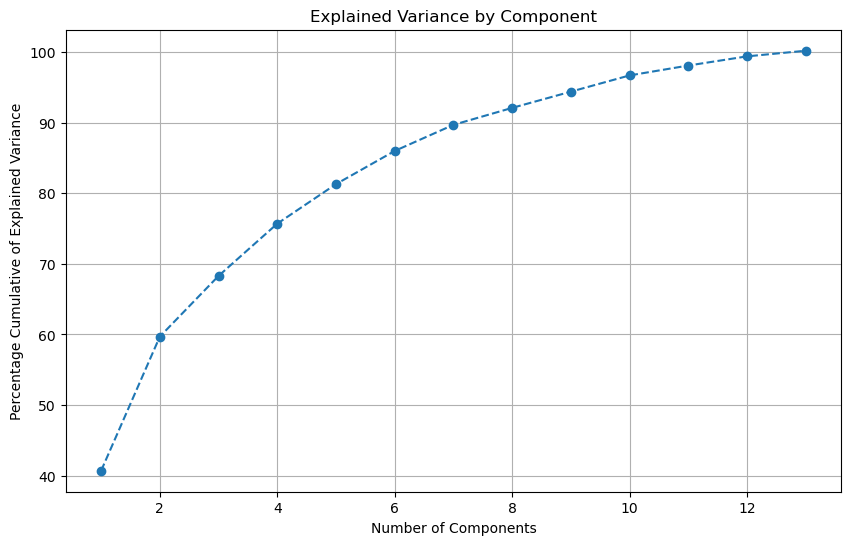

In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA()
pca.fit(normal_values)
per_var = np.round(pca.explained_variance_ratio_*100, decimals = 1)

plt.figure(figsize = (10,6))
plt.plot(range(1, len(per_var)+1), per_var.cumsum(), marker = "o", linestyle = "--")
plt.grid()
plt.ylabel("Percentage Cumulative of Explained Variance")
plt.xlabel("Number of Components")
plt.title("Explained Variance by Component")
plt.show()

S grafa možemo vidjeti da se za 2 komponente očuva oko 60% varijacije, što je manje od idealnog, ali ćemo tako lakše moći kasnije vizualizirati podatke.

Provodimo `PCA` algoritam.

In [21]:
pca = PCA(n_components = 2)
pca.fit(normal_values)
scores_pca = pca.transform(normal_values)
scores_pca

array([[ 7.06335756e-01,  2.53192753e-01],
       [ 4.84976802e-01,  8.82289142e-03],
       [ 5.21172266e-01,  1.89187222e-01],
       [ 8.21643663e-01,  5.80905512e-01],
       [ 2.02546382e-01,  5.94665740e-02],
       [ 6.08190152e-01,  4.87519191e-01],
       [ 5.44047399e-01,  3.00196497e-01],
       [ 4.74357495e-01,  2.98197021e-01],
       [ 5.00432012e-01,  3.07602859e-01],
       [ 6.27517969e-01,  2.06328233e-01],
       [ 7.27467157e-01,  3.56512044e-01],
       [ 3.74967744e-01,  2.25424535e-01],
       [ 4.48188283e-01,  2.31938139e-01],
       [ 6.26345329e-01,  3.55138677e-01],
       [ 8.35717011e-01,  5.38047802e-01],
       [ 4.71931568e-01,  3.37405385e-01],
       [ 4.26990905e-01,  4.50842684e-01],
       [ 3.66595704e-01,  3.15750341e-01],
       [ 7.18788533e-01,  5.93881332e-01],
       [ 4.58884986e-01,  1.75782240e-01],
       [ 6.61852288e-01,  1.27831032e-01],
       [ 2.67900032e-01, -9.81127565e-03],
       [ 5.99782399e-01, -7.82494523e-04],
       [ 4.

Sada vizualiziramo podatke u novo dobivenom 2-dimenzionalnom formatu.

Text(0, 0.5, 'X2')

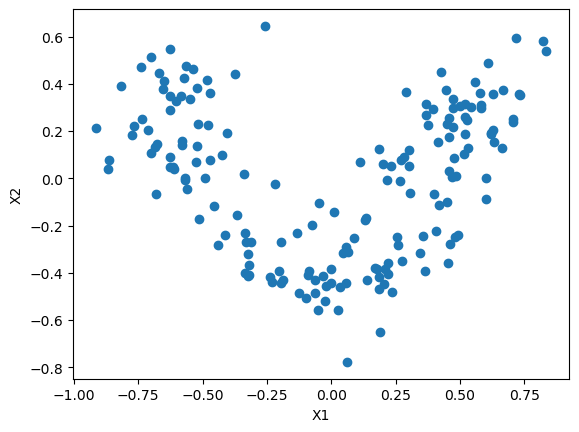

In [22]:
import matplotlib.pyplot as plt

X1=scores_pca[:,0]
X2=scores_pca[:,1]
plt.scatter(X1, X2)
plt.xlabel('X1')
plt.ylabel('X2')

Zatim utvrđujemo pogodan broj klastera za `k-means` algoritam.

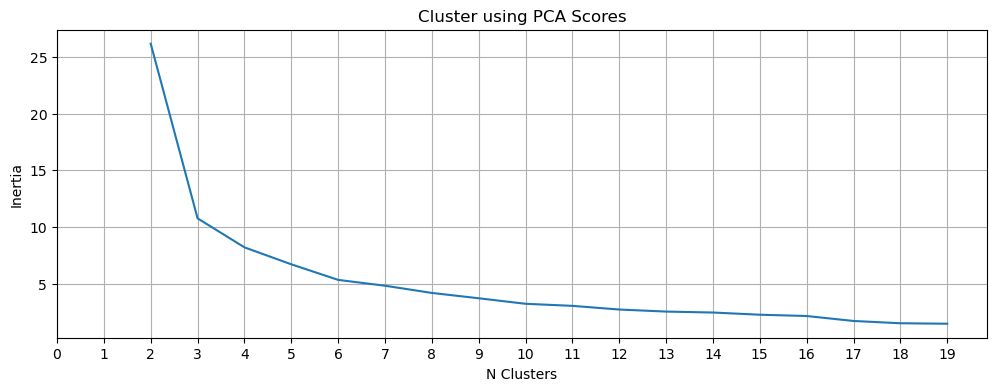

In [23]:
from sklearn.cluster import KMeans

inercija = []

for k in range(2, 20):
    kmeans_pca = KMeans(random_state=0, n_clusters=k)
    kmeans_pca.fit(scores_pca)
    inercija.append(kmeans_pca.inertia_)

plt.figure(figsize=(12, 4))
plt.grid()
plt.plot(range(2, 20), inercija)
plt.xticks(range(0, 20))
plt.title("Cluster using PCA Scores")
plt.ylabel("Inertia")
plt.xlabel("N Clusters")
plt.show()

Uzmimo 3 klastera te provedimo algoritam za klasteriranje.

In [24]:
kmeans_pca = KMeans(n_clusters = 3, random_state = 0)
kmeans_pca.fit(scores_pca)

KMeans(n_clusters=3, random_state=0)

Sada još novim `DataFrame`-om `df_clust_pca_kmeans` objedinjujemo početne podatke, rezultate smanjenja dimenzionalnosti i svakom podatku pridružujemo optimalni klaster određen `k-means` algoritmom.

In [25]:
df_clust_pca_kmeans = pd.concat([df, pd.DataFrame(scores_pca)], axis = 1)
df_clust_pca_kmeans.columns.values[-2:] = ["comp1", "comp2"]
df_clust_pca_kmeans["cluster_kmeans_pca"] = kmeans_pca.labels_
df_clust_pca_kmeans

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,comp1,comp2,cluster_kmeans_pca
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0.706336,0.253193,2
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0.484977,0.008823,2
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0.521172,0.189187,2
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0.821644,0.580906,2
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0.202546,0.059467,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,-0.739510,0.471901,1
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,-0.581781,0.348366,1
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,-0.626313,0.546857,1
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,-0.572991,0.425516,1


Za kraj vizualiziramo rezultate klasteriranja.

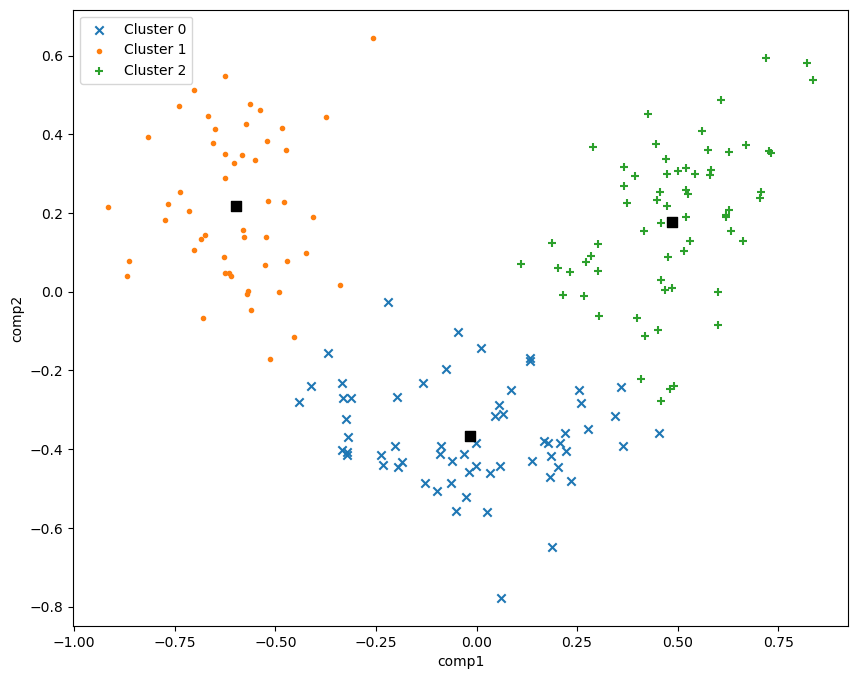

In [26]:
plt.figure(figsize=(10, 8))
markers = ['x', '.', '+']

for i in range(0, 3):
    cond = df_clust_pca_kmeans['cluster_kmeans_pca'] == i
    df2 = df_clust_pca_kmeans[cond] 
    plt.scatter(df2['comp1'], df2['comp2'], label = 'Cluster '+str(i), marker = markers[i])

plt.scatter(kmeans_pca.cluster_centers_[:, 0], kmeans_pca.cluster_centers_[:, 1], color = 'black', s = 50, marker = "s")
plt.xlabel('comp1')
plt.ylabel('comp2')
plt.legend()

Graf jasno pokazuje 3 klastera u ovom 2-dimenzionalnom prikazu. Bez daljnje analize ne možemo komentirati koje su karakteristike ovih klastera zbog korištenja PCA metode, odnosno smanjivanja dimenzionalnosti podatka.